CSV guardado en: simulacion_decaimientos_events.csv
Figura guardada: results\hist_M_reco_all.png
Figura guardada: results\hist_M_reco_by_proc.png
Figura guardada: results\armenteros_all.png
Figura actualizada: results/armenteros_by_proc.png
Conteos en ventanas alrededor de picos (estimación):
  K0 (~497.6 MeV) dentro ±20 MeV: 7392
  Lambda (~1115.7 MeV) dentro ±25 MeV: 14262
Total events: 30000 (K0 true = 7411, Lambda true = 7416)
Simulación completada.


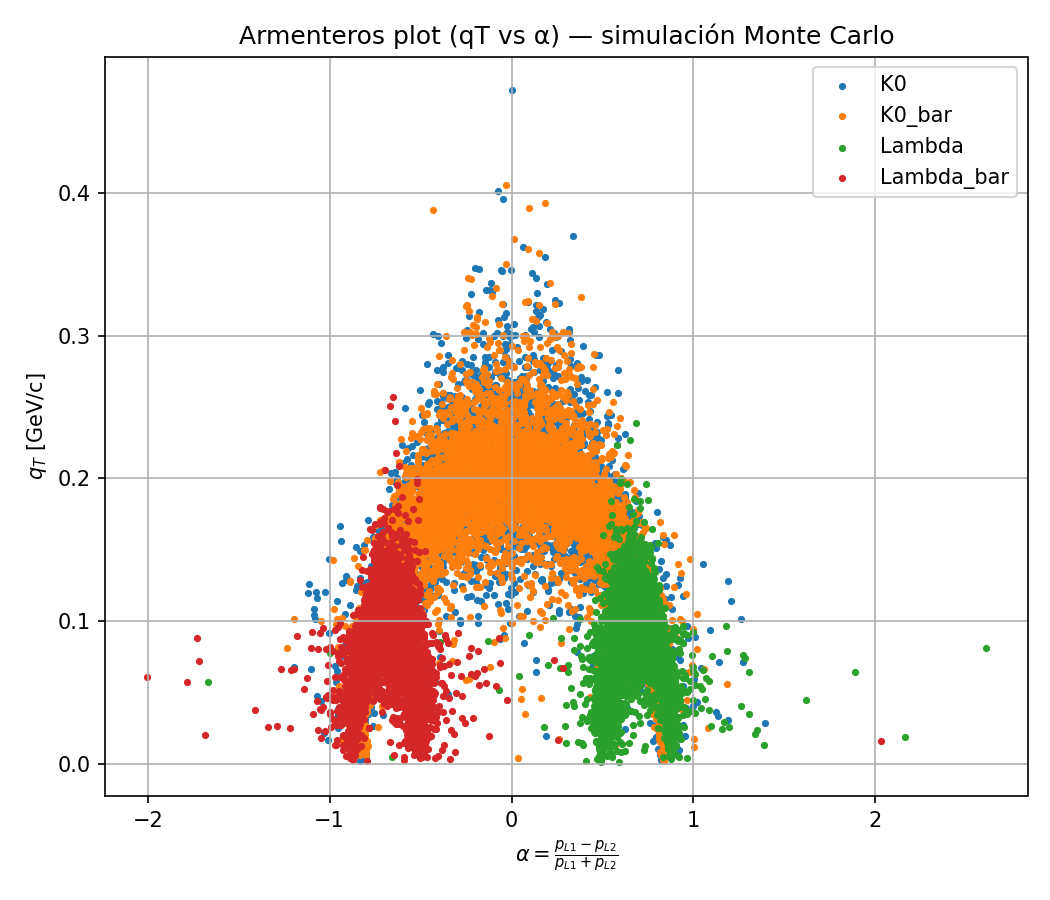

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---------------------------
# Constantes (MeV, c = 1)
# ---------------------------
m_pi = 139.570      # masa del pion
m_p  = 938.272      # masa del protón
m_K0 = 497.611      # masa K0 (neutral)
m_L  = 1115.683     # masa Lambda0

# ---------------------------
# Utilidades físicas
# ---------------------------
def energy_to_p(E, m):
    """Dada energía total E y masa m, devuelve el módulo del momento p (MeV)."""
    p2 = E**2 - m**2
    return np.sqrt(np.maximum(p2, 0.0))

def two_body_decay_momenta(M, m1, m2):
    """En el frame de reposo de la madre M -> m1 + m2.
       Devuelve (E1, p1, E2, p2) con p1 = p2 magnitud."""
    E1 = (M**2 + m1**2 - m2**2) / (2.0*M)
    E2 = (M**2 + m2**2 - m1**2) / (2.0*M)
    p1 = energy_to_p(E1, m1)
    p2 = energy_to_p(E2, m2)
    return E1, p1, E2, p2

def random_direction():
    """Devuelve vector unitario isotrópico en 3D y sus ángulos (theta, phi)."""
    cos_theta = 2.0*np.random.rand() - 1.0
    theta = np.arccos(cos_theta)
    phi = 2.0*np.pi*np.random.rand()
    ux = np.sin(theta)*np.cos(phi)
    uy = np.sin(theta)*np.sin(phi)
    uz = cos_theta
    return np.array([ux, uy, uz]), theta, phi

def lorentz_boost(p4, beta_vec):
    """
    Boost de 4-vector p4=(E, px, py, pz) por velocidad beta_vec (vector, c=1).
    (Transformación simple; asumimos |beta| < 1)
    """
    beta = np.linalg.norm(beta_vec)
    if beta == 0:
        return p4.copy()
    gamma = 1.0/np.sqrt(1.0-beta**2)
    bp = np.dot(beta_vec, p4[1:])
    E_prime = gamma*(p4[0] + bp)
    # componente espacial transformada:
    p_par = p4[1:] + ((gamma-1.0)/beta**2) * (np.dot(p4[1:], beta_vec)) * beta_vec + gamma * beta_vec * p4[0]
    # nota: la forma se reorganizó para evitar errores numéricos menores
    # Una forma alternativa (clásica) es dividir en paralelo/perpendicular, pero esta es suficiente aquí.
    return np.concatenate(([E_prime], p_par))

# ---------------------------
# Smearing (resolución detector)
# ---------------------------
def smear_vector(vec, frac_p=0.05, smear_angle=0.01):
    """Aplica smear a la magnitud del momento y a los ángulos (theta, phi)."""
    x,y,z = vec
    r = np.linalg.norm(vec)
    if r == 0:
        return vec.copy()
    # magnitud smeared
    p_obs = np.random.normal(r, frac_p * r)
    # ángulos actuales
    theta = np.arccos(np.clip(z/r, -1.0, 1.0))
    phi = np.arctan2(y, x)
    theta_obs = np.random.normal(theta, smear_angle * max(1.0, theta))
    phi_obs = np.random.normal(phi, smear_angle * max(1.0, abs(phi)))
    vx = p_obs * np.sin(theta_obs)*np.cos(phi_obs)
    vy = p_obs * np.sin(theta_obs)*np.sin(phi_obs)
    vz = p_obs * np.cos(theta_obs)
    return np.array([vx, vy, vz])

# ---------------------------
# Simulación principal
# ---------------------------
def simulate(N=30000, seed=42,
             E_min=600.0, E_max=10000.0,
             frac_p_smear=0.05, angle_smear=0.01,
             out_csv="simulacion_decaimientos_events.csv",
             save_plots=True, outdir="results"):
    """
    Ejecuta la simulación.
    N: número de eventos
    E_min, E_max: energía total de la madre en lab (MeV)
    frac_p_smear: fracción de smear en magnitud de p
    angle_smear: smear en ángulos (rad)
    """
    np.random.seed(seed)
    events = []

    for i in range(N):
        # seleccionar proceso (50/50)
        r = np.random.rand()
        if r < 0.25:
            proc = "K0"
            M = m_K0
            m1 = m_pi
            m2 = m_pi
        elif r < 0.5:
            proc = "K0_bar"
            M = m_K0
            m1 = m_pi
            m2 = m_pi
        elif r < 0.75:
            proc = "Lambda"
            M = m_L
            m1 = m_p
            m2 = m_pi
        else:
            proc = "Lambda_bar"
            M = m_L
            m1 = m_pi   # intercambia masas → p̅ y π⁺
            m2 = m_p


        # energía total de la madre en laboratorio
        E_lab = np.random.uniform(max(M*1.001, E_min), E_max)
        p_lab_mag = energy_to_p(E_lab, M)
        uM, thetaM, phiM = random_direction()
        pM_lab = p_lab_mag * uM
        betaM = pM_lab / E_lab

        # en reposo de la madre: energías y momento de los productos
        E1_rest, p1_rest_mag, E2_rest, p2_rest_mag = two_body_decay_momenta(M, m1, m2)

        # dirección aleatoria para el producto 1 en reposo
        u1_rest, theta1_rest, phi1_rest = random_direction()
        p1_rest = p1_rest_mag * u1_rest
        p2_rest = -p1_rest

        p4_1_rest = np.concatenate(([E1_rest], p1_rest))
        p4_2_rest = np.concatenate(([E2_rest], p2_rest))

        # boost al laboratorio
        p4_1_lab = lorentz_boost(p4_1_rest, betaM)
        p4_2_lab = lorentz_boost(p4_2_rest, betaM)

        # smear (observables)
        p1_obs = smear_vector(p4_1_lab[1:], frac_p=frac_p_smear, smear_angle=angle_smear)
        p2_obs = smear_vector(p4_2_lab[1:], frac_p=frac_p_smear, smear_angle=angle_smear)
        E1_obs = np.sqrt(np.sum(p1_obs**2) + m1**2)
        E2_obs = np.sqrt(np.sum(p2_obs**2) + m2**2)

        # masa invariante reconstruida
        E_tot_obs = E1_obs + E2_obs
        p_tot_obs = p1_obs + p2_obs
        M_reco = np.sqrt(max(E_tot_obs**2 - np.sum(p_tot_obs**2), 0.0))

        # Variables Armenteros:
        # qT: módulo del momento de p1 perpendicular a la dirección del p_tot
        p_tot = p_tot_obs
        p_tot_norm = np.linalg.norm(p_tot)
        if p_tot_norm < 1e-12:
            p_tot_dir = np.array([0.0, 0.0, 1.0])
        else:
            p_tot_dir = p_tot / p_tot_norm

        qT = np.linalg.norm(p1_obs - np.dot(p1_obs, p_tot_dir)*p_tot_dir)
        pL1 = np.dot(p1_obs, p_tot_dir)
        pL2 = np.dot(p2_obs, p_tot_dir)
        alpha = (pL1 - pL2) / (pL1 + pL2 + 1e-12)

        events.append({
            "proc": proc,
            "M_true": M,
            "E_lab": E_lab,
            "p_lab_mag": p_lab_mag,
            "M_reco": M_reco,
            "qT": qT,
            "alpha": alpha,
            "p1_mag_obs": np.linalg.norm(p1_obs),
            "p2_mag_obs": np.linalg.norm(p2_obs),
            "thetaM": thetaM,
            "phiM": phiM
        })

    df = pd.DataFrame(events)

    # crear carpeta de resultados
    if save_plots and not os.path.exists(outdir):
        os.makedirs(outdir, exist_ok=True)

    # Guardar CSV
    df.to_csv(out_csv, index=False)
    print(f"CSV guardado en: {out_csv}")

    # Plots
    if save_plots:
        # 1) Histograma masa invariante (todos)
        plt.figure(figsize=(8,5))
        plt.hist(df["M_reco"], bins=150, range=(100,1300))
        plt.title("Histograma de masa invariante reconstruida (M_reco)")
        plt.xlabel("M_reco [MeV]")
        plt.ylabel("Eventos")
        plt.grid(True)
        f1 = os.path.join(outdir, "hist_M_reco_all.png")
        plt.tight_layout()
        plt.savefig(f1, dpi=150)
        plt.close()
        print(f"Figura guardada: {f1}")

        # 2) Histogramas por proceso
        plt.figure(figsize=(8,5))
        plt.hist(df[df.proc=="K0"]["M_reco"], bins=120, range=(200,800), alpha=0.7, label="K0 reco")
        plt.hist(df[df.proc=="Lambda"]["M_reco"], bins=120, range=(800,1300), alpha=0.7, label="Lambda reco")
        plt.title("Masa reconstruida por proceso (K0 vs Lambda)")
        plt.xlabel("M_reco [MeV]")
        plt.ylabel("Eventos")
        plt.legend()
        plt.grid(True)
        f2 = os.path.join(outdir, "hist_M_reco_by_proc.png")
        plt.tight_layout()
        plt.savefig(f2, dpi=150)
        plt.close()
        print(f"Figura guardada: {f2}")

        # 3) Armenteros plot (qT vs alpha)
        plt.figure(figsize=(7,6))
        plt.scatter(df["alpha"], df["qT"], s=6)
        plt.title("Armenteros plot (qT vs alpha) — eventos simulados")
        plt.xlabel("alpha")
        plt.ylabel("qT [MeV]")
        plt.grid(True)
        f3 = os.path.join(outdir, "armenteros_all.png")
        plt.tight_layout()
        plt.savefig(f3, dpi=150)
        plt.close()
        print(f"Figura guardada: {f3}")

        
        # 4) Armenteros por proceso (incluyendo antipartículas)
        plt.figure(figsize=(7,6))

        mask_K0      = df.proc == "K0"
        mask_K0_bar  = df.proc == "K0_bar"
        mask_Lambda  = df.proc == "Lambda"
        mask_LambdaB = df.proc == "Lambda_bar"

        plt.scatter(df[mask_K0]["alpha"],      df[mask_K0]["qT"]/1000, s=6, label="K0")
        plt.scatter(df[mask_K0_bar]["alpha"],  df[mask_K0_bar]["qT"]/1000, s=6, label="K0_bar")
        plt.scatter(df[mask_Lambda]["alpha"],  df[mask_Lambda]["qT"]/1000, s=6, label="Lambda")
        plt.scatter(df[mask_LambdaB]["alpha"], df[mask_LambdaB]["qT"]/1000, s=6, label="Lambda_bar")

        plt.title("Armenteros plot (qT vs α) — simulación Monte Carlo")
        plt.xlabel(r"$\alpha = \frac{p_{L1}-p_{L2}}{p_{L1}+p_{L2}}$")
        plt.ylabel(r"$q_T$ [GeV/c]")   # ahora en GeV/c, divide por 1000
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(outdir, "armenteros_by_proc.png"), dpi=150)
        plt.close()
        print("Figura actualizada: results/armenteros_by_proc.png")


    # Resumen rápido de conteos alrededor de la masa verdadera
    def count_peak(df, center, width):
        return ((df["M_reco"] > center-width) & (df["M_reco"] < center+width)).sum()

    count_K0 = count_peak(df, m_K0, 20.0)
    count_L  = count_peak(df, m_L, 25.0)
    print("Conteos en ventanas alrededor de picos (estimación):")
    print(f"  K0 (~{m_K0:.1f} MeV) dentro ±20 MeV: {count_K0}")
    print(f"  Lambda (~{m_L:.1f} MeV) dentro ±25 MeV: {count_L}")
    print(f"Total events: {len(df)} (K0 true = {(df.proc=='K0').sum()}, Lambda true = {(df.proc=='Lambda').sum()})")

    return df

# ---------------------------
# Ejecución si se ejecuta como script
# ---------------------------
if __name__ == "__main__":
    # parámetros por defecto
    df = simulate(N=30000,
                  seed=42,
                  E_min=600.0,    # MeV
                  E_max=10000.0,  # MeV
                  frac_p_smear=0.05,
                  angle_smear=0.01,
                  out_csv="simulacion_decaimientos_events.csv",
                  save_plots=True,
                  outdir="results")
    print("Simulación completada.")
from IPython.display import Image
Image("results/armenteros_by_proc.png")
